In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from avaml.aggregatedata import ForecastDataset, LabeledData, REG_ENG, CsvMissingError

# Introduction

The goal of this Jupyter Notebook is to get a better idea of how our input and output features are formatted. Additionally, I will be looking at how different variables vary, both temporally and spatially. I believe this is important because in order to train a machine learning model, we will need to split the data somehow. 

However, my intuition is that there will be a lot of inter-seasonal variability, making a data split on years or seasons (over all regions) a bad choice. In some ways, you could look at splitting the data over years or seasons as a best-worst case scenario. That is, if there is a lot of variability through time, predicting for a new season could be as good or bad as the model is able to predict output features. And due to climate change, we may very well get data that looks quite different from historical records, making the model ill-suited to predict new data.

My hypothesis is that splitting the data by regions is a better choice. There are 23 regions in total, so you could imagine splitting the input data into 3 groups for a training, validation, and test set. The key to this approach is to realize that regions next to each other will most likely be spatially autocorrelated. 

To overcome this bias, we will need to think about how to choose regions, say for the training set, that minimize this spatial autocorrelation. Additionally, and this is **very important**, we will also need to group the regions so that the training, validation, and testing sets have the same or very close to the same distribution of values. Otherwise, we will be training the model on one set of data, but our model will be unable to correctly predict for our "target" or test set.

# Read in data

In [2]:
model_prefix = ''
days = 1
regobs_types = list(REG_ENG.keys())
labeled_data = None
try:
    print("Reading csv")
    labeled_data = LabeledData.from_csv(days=days, regobs_types=regobs_types, with_varsom=True)
except CsvMissingError:
    print("Csv missing. Fetching online data. (This takes a long time.)")
    labeled_data = ForecastDataset(regobs_types=regobs_types).label(days=days, with_varsom=True)
    labeled_data.to_csv()

Reading csv
Csv missing. Fetching online data. (This takes a long time.)


In [3]:
labeled_data

In [4]:
vars(labeled_data).keys()

dict_keys(['data', 'row_weight', 'label', 'pred', 'days', 'with_varsom', 'regobs_types', 'single', 'seasons', 'with_regions'])

In [5]:
labeled_data.data.shape

(13115, 291)

In [6]:
labeled_data.data.head()

region_id_3001 region_id_3002 region_id_3003 region_id_3004  \
                             0              0              0              0   
2017-11-23 3031            0.0            0.0            0.0            0.0   
           3034            0.0            0.0            0.0            0.0   
2017-12-02 3003            0.0            0.0            1.0            0.0   
           3007            0.0            0.0            0.0            0.0   
           3009            0.0            0.0            0.0            0.0   

                region_id_3005 region_id_3006 region_id_3007 region_id_3008  \
                             0              0              0              0   
2017-11-23 3031            0.0            0.0            0.0            0.0   
           3034            0.0            0.0            0.0            0.0   
2017-12-02 3003            0.0            0.0            0.0            0.0   
           3007            0.0            0.0            1.0            0.0   
           3009            0.0            0.0            0.0            0.0   

                region_id_3009 region_id_3010  ... wind_chg_dir_W  \
                             0              0  ...              0   
2017-11-23 3031            0.0            0.0  ...            0.0   
           3034            0.0            0.0  ...            0.0   
2017-12-02 3003            0.0            0.0  ...            0.0   
           3007            0.0            0.0  ...            0.0   
           3009            1.0            0.0  ...            0.0   

                wind_chg_dir_NW wind_chg_start_0 wind_chg_start_6  \
                              0                0                0   
2017-11-23 3031             0.0              0.0              0.0   
           3034             0.0              0.0              0.0   
2017-12-02 3003             0.0              0.0              0.0   
           3007             0.0              0.0              0.0   
           3009             0.0              0.0              0.0   

                wind_chg_start_12 wind_chg_start_18 temp_fl_start_0  \
                                0                 0               0   
2017-11-23 3031               0.0               0.0             0.0   
           3034               0.0               0.0             0.0   
2017-12-02 3003               0.0               0.0             0.0   
           3007               0.0               1.0             0.0   
           3009               0.0               1.0             0.0   

                temp_fl_start_6 temp_fl_start_12 temp_fl_start_18  
                              0                0                0  
2017-11-23 3031             1.0              0.0              0.0  
           3034             1.0              0.0              0.0  
2017-12-02 3003             0.0              0.0              0.0  
           3007             1.0              0.0              0.0  
           3009             1.0              0.0              0.0  

[5 rows x 291 columns]

# Data formatting

In [7]:
# first, drop regions
labeled_data.data = labeled_data.drop_regions().data

# then, rename indices
labeled_data.data = labeled_data.data.rename_axis(['date','region'])
labeled_data.label = labeled_data.label.rename_axis(['date', 'region'])

# flatten the hierchy of columns to 1D
labeled_data.data.columns = [' '.join(col).strip().replace(' ', '_') for col in labeled_data.data.columns.values]
labeled_data.label.columns = [' '.join(col).strip().replace(' ', '_') for col in labeled_data.label.columns.values]

# replace double underscores with single underscores
labeled_data.data.columns = [col.replace('__', '_') for col in labeled_data.data.columns.values]
labeled_data.label.columns = [col.replace('__', '_') for col in labeled_data.label.columns.values]

# replace dashes with single underscores
labeled_data.data.columns = [col.replace('-', '_') for col in labeled_data.data.columns.values]
labeled_data.label.columns = [col.replace('-', '_') for col in labeled_data.label.columns.values]

# convert some columns in labels to type int for averaging
labeled_data.label['CLASS_problem_amount'] = labeled_data.label['CLASS_problem_amount'].astype(int)
labeled_data.label['CLASS_danger_level'] = labeled_data.label['CLASS_danger_level'].astype(int)

for column in labeled_data.label.columns:
    if column.endswith(('_dist', '_dsize', '_lev_fill', '_prob', '_trig')):
        labeled_data.label[column] = labeled_data.label[column].astype(int)
        
# below, we can try to make categorical variables in the labels numeric
# first for the emergency warning column
warning_dict = {'Ikke gitt':0,
                'Naturlig utløste skred':1}

labeled_data.label['CLASS_emergency_warning'] = labeled_data.label['CLASS_emergency_warning'].replace(warning_dict)

# and now for the class problems
problem1 = list(np.unique(labeled_data.label.loc[:, 'CLASS_problem_1'].values))
problem2 = list(np.unique(labeled_data.label.loc[:, 'CLASS_problem_2'].values))
problem3 = list(np.unique(labeled_data.label.loc[:, 'CLASS_problem_3'].values))

list_of_problems = sorted(list(np.unique(problem1 + problem2 + problem3)))
problems_dict = {'':0, 'drift-slab':1, 'glide':2, 'new-loose':3,
                 'new-slab':4, 'pwl-slab':5, 'wet-loose':6, 'wet-slab':7}

labeled_data.label['CLASS_problem_1'] = labeled_data.label['CLASS_problem_1'].replace(problems_dict)
labeled_data.label['CLASS_problem_2'] = labeled_data.label['CLASS_problem_2'].replace(problems_dict)
labeled_data.label['CLASS_problem_3'] = labeled_data.label['CLASS_problem_3'].replace(problems_dict)

In [8]:
labeled_data.data.head()

danger_level_1  emergency_warning_1  problem_amount_1  \
date       region                                                          
2017-11-23 3031               4.0                  1.0               1.0   
           3034               4.0                  1.0               1.0   
2017-12-02 3003               1.0                  1.0               1.0   
           3007               2.0                  1.0               2.0   
           3009               2.0                  1.0               2.0   

                   problem_new_loose_1  problem_wet_loose_1  \
date       region                                             
2017-11-23 3031                    0.0                  0.0   
           3034                    0.0                  0.0   
2017-12-02 3003                    0.0                  0.0   
           3007                    0.0                  0.0   
           3009                    0.0                  0.0   

                   problem_new_slab_1  problem_drift_slab_1  \
date       region                                             
2017-11-23 3031                   0.0                   3.0   
           3034                   0.0                   3.0   
2017-12-02 3003                   0.0                   3.0   
           3007                   0.0                   3.0   
           3009                   0.0                   3.0   

                   problem_pwl_slab_1  problem_wet_slab_1  problem_glide_1  \
date       region                                                            
2017-11-23 3031                   0.0                 0.0              0.0   
           3034                   0.0                 0.0              0.0   
2017-12-02 3003                   0.0                 0.0              0.0   
           3007                   2.0                 0.0              0.0   
           3009                   2.0                 0.0              0.0   

                   ...  wind_chg_dir_W_0  wind_chg_dir_NW_0  \
date       region  ...                                        
2017-11-23 3031    ...               0.0                0.0   
           3034    ...               0.0                0.0   
2017-12-02 3003    ...               0.0                0.0   
           3007    ...               0.0                0.0   
           3009    ...               0.0                0.0   

                   wind_chg_start_0_0  wind_chg_start_6_0  \
date       region                                           
2017-11-23 3031                   0.0                 0.0   
           3034                   0.0                 0.0   
2017-12-02 3003                   0.0                 0.0   
           3007                   0.0                 0.0   
           3009                   0.0                 0.0   

                   wind_chg_start_12_0  wind_chg_start_18_0  \
date       region                                             
2017-11-23 3031                    0.0                  0.0   
           3034                    0.0                  0.0   
2017-12-02 3003                    0.0                  0.0   
           3007                    0.0                  1.0   
           3009                    0.0                  1.0   

                   temp_fl_start_0_0  temp_fl_start_6_0  temp_fl_start_12_0  \
date       region                                                             
2017-11-23 3031                  0.0                1.0                 0.0   
           3034                  0.0                1.0                 0.0   
2017-12-02 3003                  0.0                0.0                 0.0   
           3007                  0.0                1.0                 0.0   
           3009                  0.0                1.0                 0.0   

                   temp_fl_start_18_0  
date       region                      
2017-11-23 3031                   0.0  
           3034                   0.0  
2017-12-02 3003              

In [9]:
labeled_data.label.head()

CLASS_danger_level  CLASS_emergency_warning  \
date       region                                                
2017-11-23 3031                     4                        0   
           3034                     4                        0   
2017-12-02 3003                     1                        0   
           3007                     2                        0   
           3009                     2                        0   

                   CLASS_problem_1  CLASS_problem_2  CLASS_problem_3  \
date       region                                                      
2017-11-23 3031                  1                0                0   
           3034                  1                0                0   
2017-12-02 3003                  1                0                0   
           3007                  5                0                0   
           3009                  5                0                0   

                   CLASS_problem_amount CLASS_drift_slab_cause  \
date       region                                                
2017-11-23 3031                       1              snowdrift   
           3034                       1              snowdrift   
2017-12-02 3003                       1              snowdrift   
           3007                       1                      0   
           3009                       1                      0   

                   CLASS_drift_slab_dist  CLASS_drift_slab_dsize  \
date       region                                                  
2017-11-23 3031                        3                       3   
           3034                        3                       3   
2017-12-02 3003                        1                       2   
           3007                        0                       0   
           3009                        0                       0   

                   CLASS_drift_slab_lev_fill  ...  REAL_new_loose_lev_max  \
date       region                             ...                           
2017-11-23 3031                            1  ...                     0.0   
           3034                            1  ...                     0.0   
2017-12-02 3003                            1  ...                     0.0   
           3007                            0  ...                     0.0   
           3009                            0  ...                     0.0   

                   REAL_new_loose_lev_min REAL_new_slab_lev_max  \
date       region                                                 
2017-11-23 3031                       0.0                   0.0   
           3034                       0.0                   0.0   
2017-12-02 3003                       0.0                   0.0   
           3007                       0.0                   0.0   
           3009                       0.0                   0.0   

                   REAL_new_slab_lev_min  REAL_pwl_slab_lev_max  \
date       region                                                 
2017-11-23 3031                      0.0                    0.0   
           3034                      0.0                    0.0   
2017-12-02 3003                      0.0                    0.0   
           3007                      0.0                  400.0   
           3009                      0.0                  400.0   

                   REAL_pwl_slab_lev_min  REAL_wet_loose_lev_max  \
date       region                                                  
2017-11-23 3031                      0.0                     0.0   
           3034                      0.0                     0.0   
2017-12-02 3003                      0.0                     0.0   
           3007                      0.0                     0.0   
           3009                      0.0                     0.0   

                   REAL_wet_loose_lev_min REAL_wet_slab_lev_max  \
date       region                                                 
2017-11-23 3031     

# Clustering data by region and time

I can look at how key variables are distributed for every region and all times. Then we can compare this to how how variables are distributed when clustering them by region or season. I am interested in understanding how certain input variables are correlated to the output variables of interest. This includes how different snow pack conditions vary with avlanche problems and danger level warnings, but also how these input and output variables change with time, across different regions, etc.

The data is formatted as a MultiIndex in Pandas. This means we can first subset by time, then by region ID.

## By time

In [10]:
# first, the overall means
label_means_all = pd.DataFrame(labeled_data.label.mean()[labeled_data.label.mean() != np.infty])
label_means_all.columns = ['all_seasons']
#label_means_all

In [11]:
# look at df from one day, there should be 21 regions
labeled_data.data.loc['2017-12-07'].shape

(21, 245)

In [12]:
labeled_data.data.loc['2017-12-07']

,danger_level_1,emergency_warning_1,problem_amount_1,problem_new_loose_1,problem_wet_loose_1,problem_new_slab_1,problem_drift_slab_1,problem_pwl_slab_1,problem_wet_slab_1,problem_glide_1,...,wind_chg_dir_W_0,wind_chg_dir_NW_0,wind_chg_start_0_0,wind_chg_start_6_0,wind_chg_start_12_0,wind_chg_start_18_0,temp_fl_start_0_0,temp_fl_start_6_0,temp_fl_start_12_0,temp_fl_start_18_0
region,,,,,,,,,,,,,,,,,,,,,
3003,1.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3007,3.0,1.0,2.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3009,3.0,1.0,2.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3010,3.0,1.0,2.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3011,3.0,1.0,2.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3012,3.0,1.0,2.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3013,3.0,1.0,2.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3014,2.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3015,3.0,1.0,2.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [13]:
labeled_data.data.loc['2017-12-07'].mean().head(6)

danger_level_1         2.666667
emergency_warning_1    0.809524
problem_amount_1       1.952381
problem_new_loose_1    0.095238
problem_wet_loose_1    0.428571
problem_new_slab_1     0.952381
dtype: float32

In [14]:
dates_list = list(labeled_data.data.index.get_level_values(0))

# for date in dates_list:
#     print(date)

In [15]:
#find start and end dates for each season
season_start_1 = 0
season_end_1 = np.where(np.array(dates_list) == '2018-05-31')[0][-1]

season_start_2 = season_end_1 + 1
season_end_2 = np.where(np.array(dates_list) == '2019-05-31')[0][-1]

season_start_3 = season_end_2 + 1
season_end_3 = np.where(np.array(dates_list) == '2020-06-14')[0][-1]

season_start_4 = season_end_3 + 1

print('Season 1 dates: from {} until {}'.format(dates_list[season_start_1], dates_list[season_end_1]))
print('Season 2 dates: from {} until {}'.format(dates_list[season_start_2], dates_list[season_end_2]))
print('Season 3 dates: from {} until {}'.format(dates_list[season_start_3], dates_list[season_end_3]))
print('Season 4 dates: from {} until {}'.format(dates_list[season_start_4], dates_list[-1]))

Season 1 dates: from 2017-11-23 until 2018-05-31
Season 2 dates: from 2018-12-01 until 2019-05-31
Season 3 dates: from 2019-12-02 until 2020-06-14
Season 4 dates: from 2020-12-02 until 2021-01-12


In [16]:
first_data = labeled_data.data.iloc[:season_end_1+1]
second_data = labeled_data.data.iloc[season_start_2:season_end_2+1]
third_data = labeled_data.data.iloc[season_start_3:season_end_3+1]
fourth_data = labeled_data.data.iloc[season_start_4:]

first_labels = labeled_data.label.iloc[:season_end_1]
second_labels = labeled_data.label.iloc[season_start_2:season_end_2]
third_labels = labeled_data.label.iloc[season_start_3:season_end_3]
fourth_labels = labeled_data.label.iloc[season_start_4:]

In [17]:
print('Dataframe for 2017-2018 season has {} data points.'.format(len(first_data)))
print('Dataframe for 2018-2019 season has {} data points.'.format(len(second_data)))
print('Dataframe for 2019-2020 season has {} data points.'.format(len(third_data)))
print('Dataframe for 2020-2021 season has {} data points.'.format(len(fourth_data)))

Dataframe for 2017-2018 season has 3814 data points.
Dataframe for 2018-2019 season has 3906 data points.
Dataframe for 2019-2020 season has 4429 data points.
Dataframe for 2020-2021 season has 966 data points.


In [18]:
length_all_seasons = len(first_data) + len(second_data) + len(third_data) + len(fourth_data)
assert(length_all_seasons == len(labeled_data.data))

In [19]:
first_labels.head()

CLASS_danger_level  CLASS_emergency_warning  \
date       region                                                
2017-11-23 3031                     4                        0   
           3034                     4                        0   
2017-12-02 3003                     1                        0   
           3007                     2                        0   
           3009                     2                        0   

                   CLASS_problem_1  CLASS_problem_2  CLASS_problem_3  \
date       region                                                      
2017-11-23 3031                  1                0                0   
           3034                  1                0                0   
2017-12-02 3003                  1                0                0   
           3007                  5                0                0   
           3009                  5                0                0   

                   CLASS_problem_amount CLASS_drift_slab_cause  \
date       region                                                
2017-11-23 3031                       1              snowdrift   
           3034                       1              snowdrift   
2017-12-02 3003                       1              snowdrift   
           3007                       1                      0   
           3009                       1                      0   

                   CLASS_drift_slab_dist  CLASS_drift_slab_dsize  \
date       region                                                  
2017-11-23 3031                        3                       3   
           3034                        3                       3   
2017-12-02 3003                        1                       2   
           3007                        0                       0   
           3009                        0                       0   

                   CLASS_drift_slab_lev_fill  ...  REAL_new_loose_lev_max  \
date       region                             ...                           
2017-11-23 3031                            1  ...                     0.0   
           3034                            1  ...                     0.0   
2017-12-02 3003                            1  ...                     0.0   
           3007                            0  ...                     0.0   
           3009                            0  ...                     0.0   

                   REAL_new_loose_lev_min REAL_new_slab_lev_max  \
date       region                                                 
2017-11-23 3031                       0.0                   0.0   
           3034                       0.0                   0.0   
2017-12-02 3003                       0.0                   0.0   
           3007                       0.0                   0.0   
           3009                       0.0                   0.0   

                   REAL_new_slab_lev_min  REAL_pwl_slab_lev_max  \
date       region                                                 
2017-11-23 3031                      0.0                    0.0   
           3034                      0.0                    0.0   
2017-12-02 3003                      0.0                    0.0   
           3007                      0.0                  400.0   
           3009                      0.0                  400.0   

                   REAL_pwl_slab_lev_min  REAL_wet_loose_lev_max  \
date       region                                                  
2017-11-23 3031                      0.0                     0.0   
           3034                      0.0                     0.0   
2017-12-02 3003                      0.0                     0.0   
           3007                      0.0                     0.0   
           3009                      0.0                     0.0   

                   REAL_wet_loose_lev_min REAL_wet_slab_lev_max  \
date       region                                                 
2017-11-23 3031     

In [20]:
first_labels.tail()

CLASS_danger_level  CLASS_emergency_warning  \
date       region                                                
2018-05-31 3028                     1                        0   
           3029                     1                        0   
           3031                     1                        0   
           3032                     1                        0   
           3034                     1                        0   

                   CLASS_problem_1  CLASS_problem_2  CLASS_problem_3  \
date       region                                                      
2018-05-31 3028                  6                0                0   
           3029                  6                0                0   
           3031                  6                0                0   
           3032                  6                0                0   
           3034                  6                0                0   

                   CLASS_problem_amount CLASS_drift_slab_cause  \
date       region                                                
2018-05-31 3028                       1                      0   
           3029                       1                      0   
           3031                       1                      0   
           3032                       1                      0   
           3034                       1                      0   

                   CLASS_drift_slab_dist  CLASS_drift_slab_dsize  \
date       region                                                  
2018-05-31 3028                        0                       0   
           3029                        0                       0   
           3031                        0                       0   
           3032                        0                       0   
           3034                        0                       0   

                   CLASS_drift_slab_lev_fill  ...  REAL_new_loose_lev_max  \
date       region                             ...                           
2018-05-31 3028                            0  ...                     0.0   
           3029                            0  ...                     0.0   
           3031                            0  ...                     0.0   
           3032                            0  ...                     0.0   
           3034                            0  ...                     0.0   

                   REAL_new_loose_lev_min REAL_new_slab_lev_max  \
date       region                                                 
2018-05-31 3028                       0.0                   0.0   
           3029                       0.0                   0.0   
           3031                       0.0                   0.0   
           3032                       0.0                   0.0   
           3034                       0.0                   0.0   

                   REAL_new_slab_lev_min  REAL_pwl_slab_lev_max  \
date       region                                                 
2018-05-31 3028                      0.0                    0.0   
           3029                      0.0                    0.0   
           3031                      0.0                    0.0   
           3032                      0.0                    0.0   
           3034                      0.0                    0.0   

                   REAL_pwl_slab_lev_min  REAL_wet_loose_lev_max  \
date       region                                                  
2018-05-31 3028                      0.0                  1400.0   
           3029                      0.0                  1200.0   
           3031                      0.0                  1200.0   
           3032                      0.0                  1500.0   
           3034                      0.0                  1200.0   

                   REAL_wet_loose_lev_min REAL_wet_slab_lev_max  \
date       region                                                 
2018-05-31 3028     

In [21]:
season_labels = [first_labels, second_labels, third_labels, fourth_labels]
season_label_means = [df.mean() for df in season_labels]

In [22]:
label_means_seasons = pd.concat(season_label_means, axis=1)
label_means_seasons.columns = ['2017-2018', '2018-2019', '2019-2020', '2020-2021']

drop_list = ['MULTI_wet_slab_aspect', 'MULTI_glide_aspect', 'MULTI_new_loose_aspect',
            'MULTI_new_slab_aspect', 'MULTI_pwl_slab_aspect', 'MULTI_wet_loose_aspect',
            'MULTI_wet_slab_aspect', 'MULTI_drift_slab_aspect', 'CLASS_glide_cause']

label_means_seasons = label_means_seasons.drop(index=drop_list)

In [23]:
reordered_idx = ['2017-2018', '2018-2019', '2019-2020', '2020-2021', 'all_seasons']
compare_means = pd.concat([label_means_all, label_means_seasons], axis=1).T.loc[reordered_idx, :]
compare_means

,CLASS_danger_level,CLASS_emergency_warning,CLASS_problem_1,CLASS_problem_2,CLASS_problem_3,CLASS_problem_amount,CLASS_drift_slab_dist,CLASS_drift_slab_dsize,CLASS_drift_slab_lev_fill,CLASS_drift_slab_prob,...,REAL_new_loose_lev_max,REAL_new_loose_lev_min,REAL_new_slab_lev_max,REAL_new_slab_lev_min,REAL_pwl_slab_lev_max,REAL_pwl_slab_lev_min,REAL_wet_loose_lev_max,REAL_wet_loose_lev_min,REAL_wet_slab_lev_max,REAL_wet_slab_lev_min
2017-2018,2.120378,0.103331,3.349069,2.478101,0.222659,1.653029,1.014162,1.153685,0.549961,1.651980,...,4.038815,0.524521,107.448204,2.386572,297.141359,43.063205,248.308419,46.236559,82.507212,15.892998
2018-2019,2.037132,0.102177,3.308067,2.073752,0.195903,1.513444,0.962612,1.107810,0.515493,1.567478,...,7.912932,1.792574,142.919334,7.631242,216.286812,26.248399,238.258643,51.241997,86.120359,22.688860
2019-2020,2.292457,0.111111,2.817751,2.511969,0.282294,1.655827,1.299232,1.540876,0.675474,2.064589,...,7.813911,7.429991,72.944896,72.944896,195.957543,178.771454,232.859079,226.490515,119.828365,106.820235
2020-2021,1.546584,0.006211,2.407867,0.506211,0.006211,1.144928,0.886128,1.044513,0.677019,2.053830,...,2.587992,2.587992,87.474120,87.474120,210.559006,203.416149,30.227743,29.296066,7.556936,6.625259
all_seasons,2.111170,0.098437,3.088601,2.223332,0.218833,1.574838,1.085398,1.262448,0.591308,1.795349,...,6.359131,3.385437,104.963782,34.037362,232.459016,95.676706,224.170797,107.403736,90.644300,47.929851


## Plotting seasonal and overall distributions

Thank you to these two resources in helping me plot multiple dataframes side by side below:
- https://stackoverflow.com/questions/38106730/plotting-multiple-histograms-in-matplotlib-colors-or-side-by-side-bars
- https://www.thetopsites.net/article/53698519.shtml

And this excellent resource for rotating axis labels for multiple subplots:
- https://www.pythoncharts.com/2019/05/17/rotating-axis-labels/

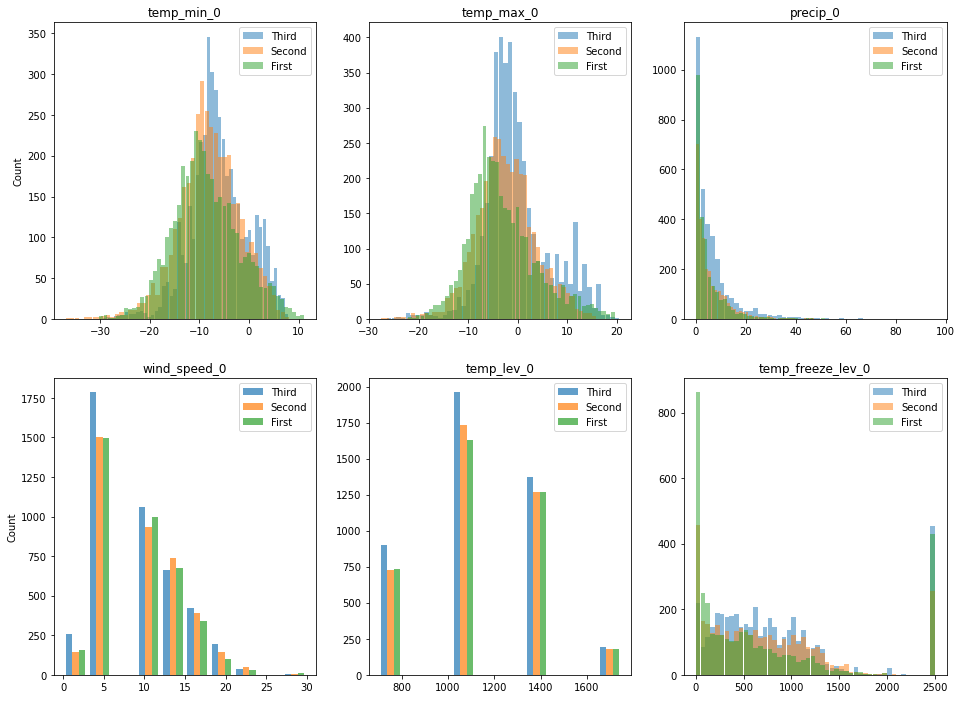

In [24]:
plot_list = ['temp_min_0', 'temp_max_0', 'precip_0', 'wind_speed_0', 'temp_lev_0', 'temp_freeze_lev_0']

# we need to do this because the third season has some really high anomolous values for precip
drop_condition_all = labeled_data.data['precip_0'].values != 0
drop_condition_first = np.logical_and(first_data['precip_0'].values != 0, first_data['precip_0'].values < 5000)
drop_condition_second = np.logical_and(second_data['precip_0'].values != 0, second_data['precip_0'].values < 5000)
drop_condition_third = np.logical_and(third_data['precip_0'].values != 0, third_data['precip_0'].values < 5000)

row, col = 0, 0

plot_kwargs = {
    "alpha": 0.5,
    "rwidth":0.95,
    "bins":50,
}

fig, ax = plt.subplots(2, 3, figsize=(16, 12))

# we are plotting the seasons in reverse order because the third season towers over the first and second
for i, column in enumerate(plot_list):
    if column == 'precip_0':
        ax[row, col].hist(third_data[column].values[drop_condition_third], label='Third', **plot_kwargs)
        ax[row, col].hist(second_data[column].values[drop_condition_second], label='Second', **plot_kwargs)
        ax[row, col].hist(first_data[column].values[drop_condition_first], label='First', **plot_kwargs)
    
    # we can plot these values side by side because they are discrete, not continuous
    elif column == 'wind_speed_0' or column == 'temp_lev_0':
        plot_dfs = [third_data[column], second_data[column], first_data[column]]
        hist_labels = ['Third', 'Second', 'First']
        ax[row, col].hist(plot_dfs, bins=10, alpha=0.7, label=hist_labels)
        
    else:
        ax[row, col].hist(third_data[column], label='Third', **plot_kwargs)
        ax[row, col].hist(second_data[column], label='Second', **plot_kwargs)
        ax[row, col].hist(first_data[column], label='First', **plot_kwargs)
    
    ax[row, col].set_xlabel(' ')
    ax[row, col].set_title(column)
    ax[row, col].legend(bbox_to_anchor=(1.0, 1.0))

    # update row and column for to move to next plot
    if(col < 2):
        col += 1
    else: 
        col = 0

    if((i+1) % 3 == 0 and i > 0):
        row += 1

ax[0, 0].set_ylabel('Count')
ax[1, 0].set_ylabel('Count')
plt.show()

### Danger level and dsize

In [25]:
def plot_label_dist(column_list, total_rows, total_cols, size, start, end, how='values', rotate=False):
    """
    Plot the distribution of values in the labels for a different column.
    
    Arguments:
       column_list(list): the list of columns you would like to plot from the different dataframes
       total_rows(int): number of subplots along y axis
       total_cols(int): number of subplots along x axis
       size(tuple): two integers, how big the Matplotlib plot should be
       start(int): column number to start plotting on
       end(int): column number to end plotting on
       how(str): either 'values' or 'means'
       rotate(bool): whether or not to rotate the x axis labels, mainly use for when axis labels are long strings
       
    Note:
        start - end should equal total_rows x total_cols
       
    Returns:
       None
    """
    row = 0
    col = 0

    fig, ax = plt.subplots(total_rows, total_cols, figsize=size)

    for i, column in enumerate(column_list[start:end]):
        
        if how == 'values':
            list_of_dfs = [first_labels[column].values, second_labels[column].values,
                           third_labels[column].values, fourth_labels[column].values,]
            hist_labels = ['first', 'second', 'third', 'fourth',]
        elif how == 'means':
            list_of_dfs = [compare_means.iloc[j][[column]] for j in range(5)]
            del list_of_dfs[3] # currently the fourth season does not have enough data and is skewing the graphs
            hist_labels = ['first', 'second', 'third', 'all']

        ax[row, col].hist(list_of_dfs, alpha=0.6, label=hist_labels)

        ax[row, col].set_title(column)
        ax[row, col].legend()
        
        # we need to draw the plot before using this method to rotate xtick labels
        if rotate == True:
            plt.draw()
            ax[row, col].set_xticklabels(ax[row, col].get_xticklabels(), rotation=30, ha='right')
        
        # update row and column for to move to next plot
        if(col < 2):
            col += 1
        else: 
            col = 0

        if((i+1) % 3 == 0 and i > 0):
            row += 1
    
    plt.show()

In [26]:
# we are interested in the danger level and dsize columns
col_list = [column for column in compare_means.columns if 'lev' in column or 'dsize' in column]

# this should be a tuple, not a list
find_lev = ('lev_fill', 'lev_max', 'lev_min')
lev_fill_min_max = [column for column in col_list if column.endswith(find_lev)]

In [27]:
# but not the lev_fill, lev_min, or lev_max columns
# those need to be processed separately
[col for col in col_list if col not in lev_fill_min_max]

['CLASS_danger_level',
 'CLASS_drift_slab_dsize',
 'CLASS_glide_dsize',
 'CLASS_new_loose_dsize',
 'CLASS_new_slab_dsize',
 'CLASS_pwl_slab_dsize',
 'CLASS_wet_loose_dsize',
 'CLASS_wet_slab_dsize']

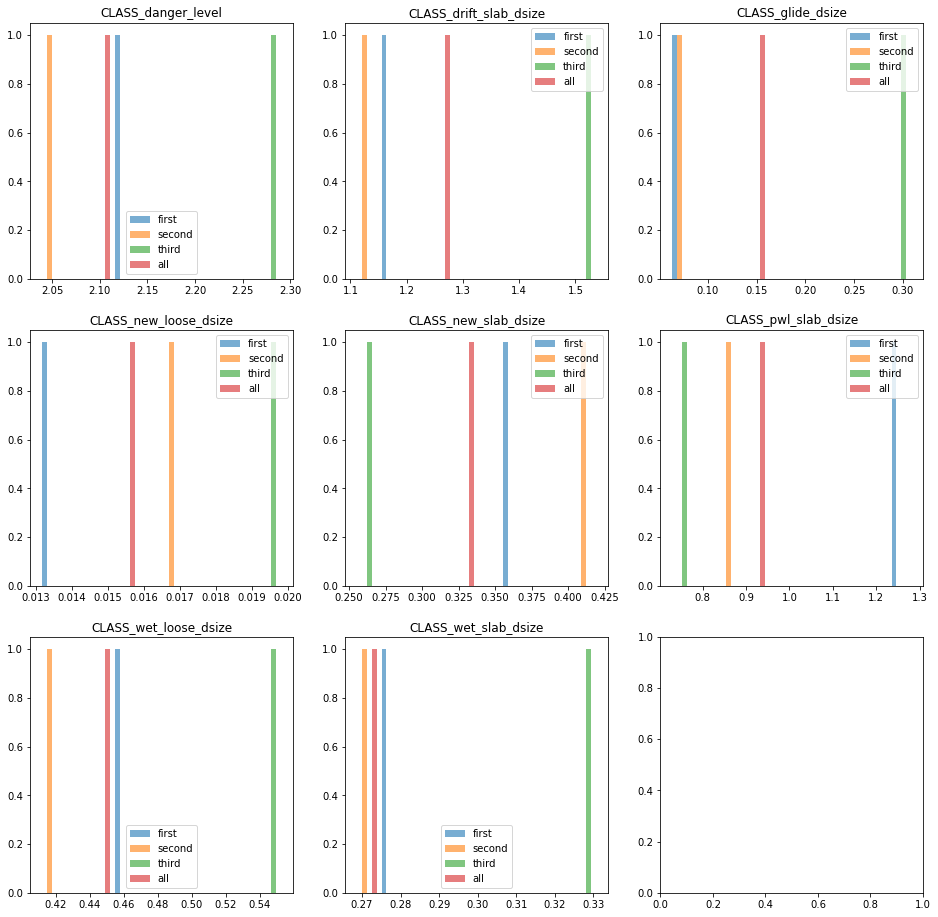

In [28]:
danger_dsize_list = [col for col in col_list if col not in lev_fill_min_max]
plot_label_dist(danger_dsize_list, 3, 3, (16, 16), 0, 12, 'means')

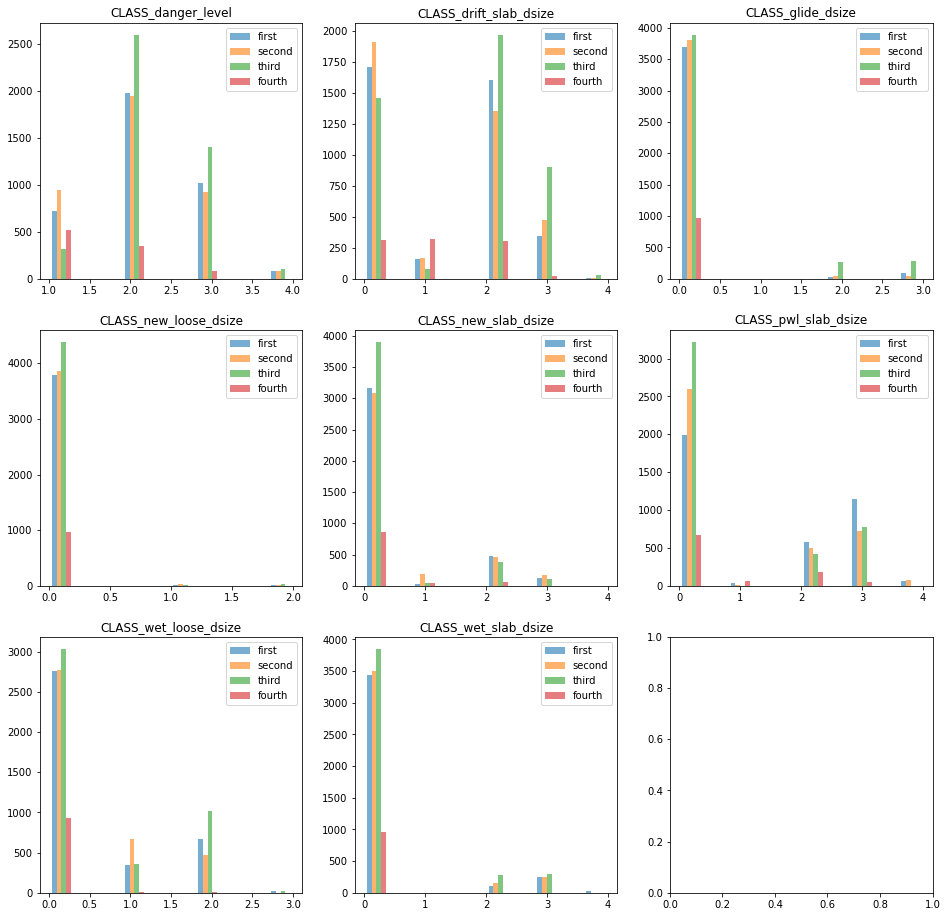

In [29]:
plot_label_dist(danger_dsize_list, 3, 3, (16, 16), 0, 9)

### Level fill, min, and max

Next, we can examine the means of the `lev_min` and `lev_max` columns after removing the places where they are 0, or "not given". Thus, these means will mean something like "of the times when we have a level min and max, what were they?".

**Note!** There are five cases for the `lev_fill` columns. This corresponds to the different drawings for where the avalanche is likely to take place (little mountain picture on RegObs).
- `0`: level is not given
- `1`: *above*: min is 0, max is height given (everything above is avalanche zone)
- `2`: *below*: min is 0, max is height given (everything below is avalanche zone)
- `3`: *above and below*: never used
- `4`: *between*: min is min given, max is max given

So to be able to plot these columns, I first need to filter out the the rows where `CLASS_..._lev_fill` is 0. Then I can create ranges, or simply plot min and max columns again.

In [30]:
class_columns = [col for col in lev_fill_min_max if col.startswith('CLASS')]
class_columns

['CLASS_drift_slab_lev_fill',
 'CLASS_glide_lev_fill',
 'CLASS_new_loose_lev_fill',
 'CLASS_new_slab_lev_fill',
 'CLASS_pwl_slab_lev_fill',
 'CLASS_wet_loose_lev_fill',
 'CLASS_wet_slab_lev_fill']

In [31]:
real_columns = [col.replace('CLASS', 'REAL') for col in class_columns]
real_columns = [[col.replace('fill', 'min'), col.replace('fill', 'max')] for col in real_columns]
real_columns

[['REAL_drift_slab_lev_min', 'REAL_drift_slab_lev_max'],
 ['REAL_glide_lev_min', 'REAL_glide_lev_max'],
 ['REAL_new_loose_lev_min', 'REAL_new_loose_lev_max'],
 ['REAL_new_slab_lev_min', 'REAL_new_slab_lev_max'],
 ['REAL_pwl_slab_lev_min', 'REAL_pwl_slab_lev_max'],
 ['REAL_wet_loose_lev_min', 'REAL_wet_loose_lev_max'],
 ['REAL_wet_slab_lev_min', 'REAL_wet_slab_lev_max']]

In [32]:
def plot_levels(level, how='values'):
    """
    Plot the distribution of values for the level min and max for a given avlanche problem,
    after subsetting for the times when it lev_fill is not 0.
    
    Arguments:
       level(int): choices are 1, 2, and 4
       
    Returns:
       None
    """

    if level not in [1, 2, 4]:
        print('Please choose a valid integer for level fill: 1, 2, or 4')
        return
    
    seasons_df = [first_labels, second_labels, third_labels, fourth_labels]
    row = 0
    col = 0

    fig, ax = plt.subplots(4, 2, figsize=(14, 20))

    for i, column in enumerate(class_columns):
        to_plot = []
        for df in seasons_df:
            subset_cols = [column] + real_columns[i]
            df_temp = df.loc[:, subset_cols]

            # replace lev_fill == 0 with NaNs for easy dropping
            df_temp[column].replace(0, np.nan, inplace=True)
            df_temp[column].dropna(inplace=True)

            # remove values where lev_fill == 3
            df_temp = df_temp[df_temp[column] != 3]
            
            # select for a specific level
            df_temp = df_temp.iloc[np.where(df_temp[column] == level)[0]]  #-> this is commented out, will plot all average
            
            if how == 'means':
                df_means = df_temp[df_temp.columns[1:].values].mean()
                if df_means.isnull().all():
                    df_means.replace(np.nan, 0, inplace=True)

                to_plot.append(df_means)
            
            else:
                to_plot.append(df_temp[df_temp.columns[1:].values].values.flatten())
        
        hist_labels = ['First', 'Second', 'Third', 'Fourth']
        ax[row, col].hist(to_plot, alpha=0.6, label=hist_labels)

        title = column[6:-5]
        ax[row, col].set_title(title)
        ax[row, col].legend()

        # update row and column for to move to next plot
        if(col < 1):
            col += 1
        else: 
            col = 0

        if((i+1) % 2 == 0 and i > 0):
            row += 1
    
    ax[3, 1].set_axis_off()
    plt.show()

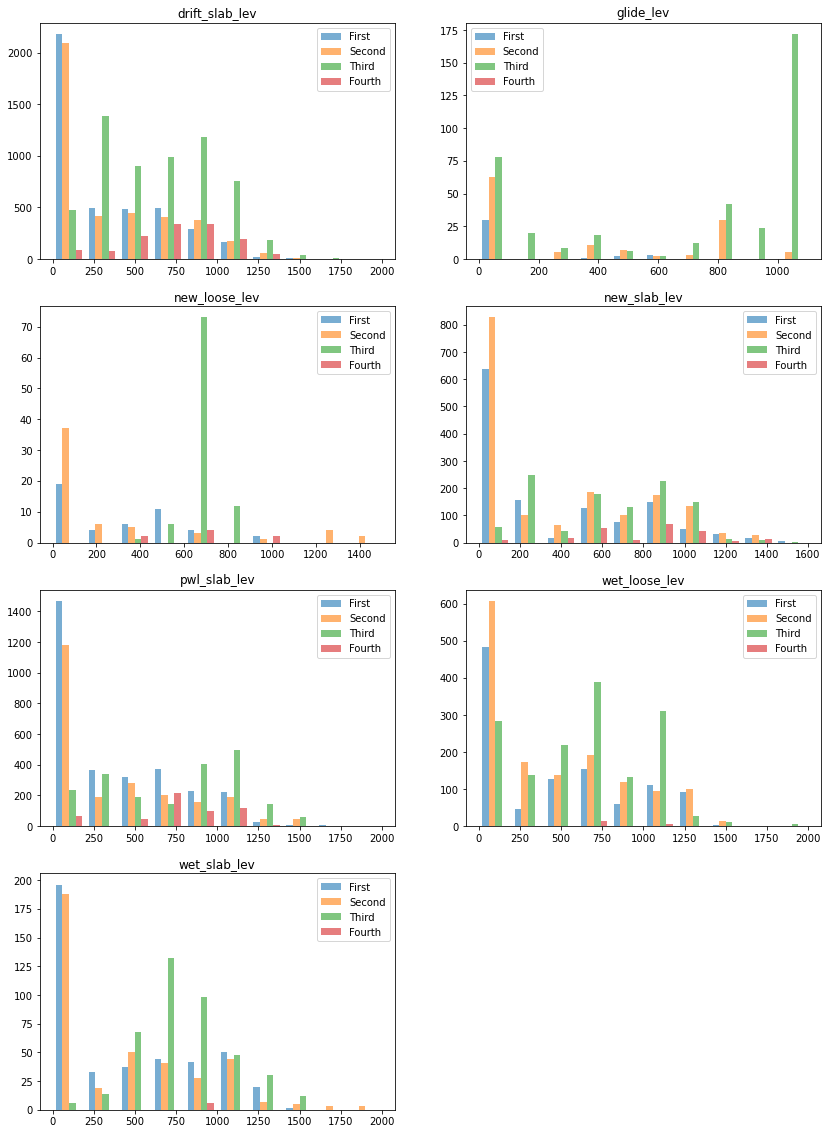

In [33]:
plot_levels(1) # everything above is avalanche zone

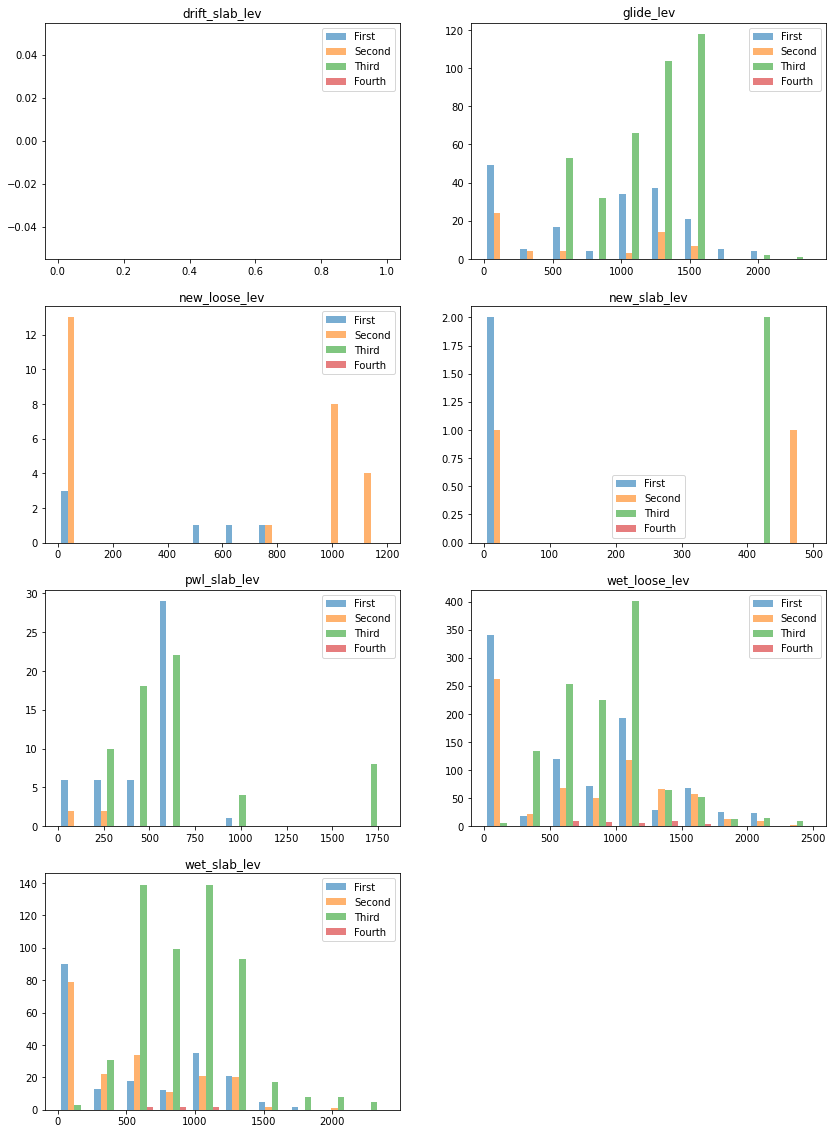

In [36]:
plot_levels(2) # everything below is avalanche zone

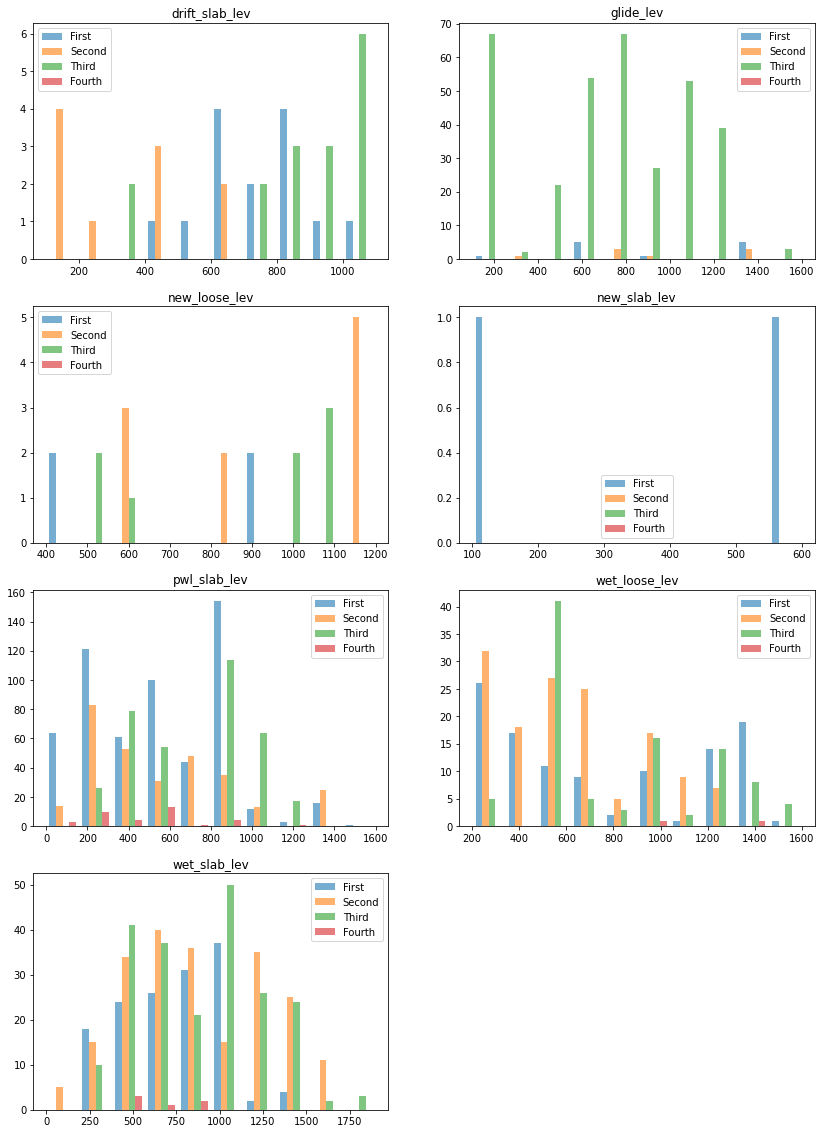

In [37]:
plot_levels(4) # everything in between is avalanche level

### Avalanche problems

Now we can look at the avalanche problems. For the avalanche problem plots, I will need to filter out where the problems are 0, or 'not given'. This will allow us better to see when the problem does occur, what *sensitivity* it has (or how likely it is to trigger an avlanche if you step on it). This is similar to what I did for the `lev_fill`, `lev_min`, and `lev_max` columns.

In [38]:
problem_list = [problem for problem in first_labels.columns.values if 'prob' in problem]
problem_list

['CLASS_problem_1',
 'CLASS_problem_2',
 'CLASS_problem_3',
 'CLASS_problem_amount',
 'CLASS_drift_slab_prob',
 'CLASS_glide_prob',
 'CLASS_new_loose_prob',
 'CLASS_new_slab_prob',
 'CLASS_pwl_slab_prob',
 'CLASS_wet_loose_prob',
 'CLASS_wet_slab_prob']

In [39]:
def plot_avalanche_problems():
    """
    Plot the distribution of values for a given avlanche problem,
    after subsetting for the times when it the columns *_prob are not 0.
       
    Returns:
       None
    """
    seasons_df = [first_labels, second_labels, third_labels, fourth_labels]
    row = 0
    col = 0

    fig, ax = plt.subplots(4, 3, figsize=(16, 18))

    for i, column in enumerate(problem_list):
        to_plot = []
        for df in seasons_df:
            
            # subset for column while keeping column name (DataFrame, not Series)
            # we will need the column name below
            df_temp = df.loc[:, problem_list]
            
            # if the column is an avalanche problem, we want to select for times when it is actually given
            # i.e., not 0
            if column.endswith('_prob'):
                # replace lev_fill == 0 with NaNs for easy dropping
                df_temp[column].replace(0, np.nan, inplace=True)                
                df_temp[column].dropna(inplace=True)
                
            to_plot.append(df_temp[column].values)
        
        hist_labels = ['First', 'Second', 'Third', 'Fourth']
        ax[row, col].hist(to_plot, alpha=0.6, label=hist_labels)

        title = column[6:]
        ax[row, col].set_title(title)
        ax[row, col].legend()

        # update row and column for to move to next plot
        if(col < 2):
            col += 1
        else: 
            col = 0

        if((i+1) % 3 == 0 and i > 0):
            row += 1
                
    ax[3, 2].set_axis_off()
    plt.show()

/home/jakidxav/anaconda3/envs/avalanche_ml/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6623: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/jakidxav/anaconda3/envs/avalanche_ml/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6624: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


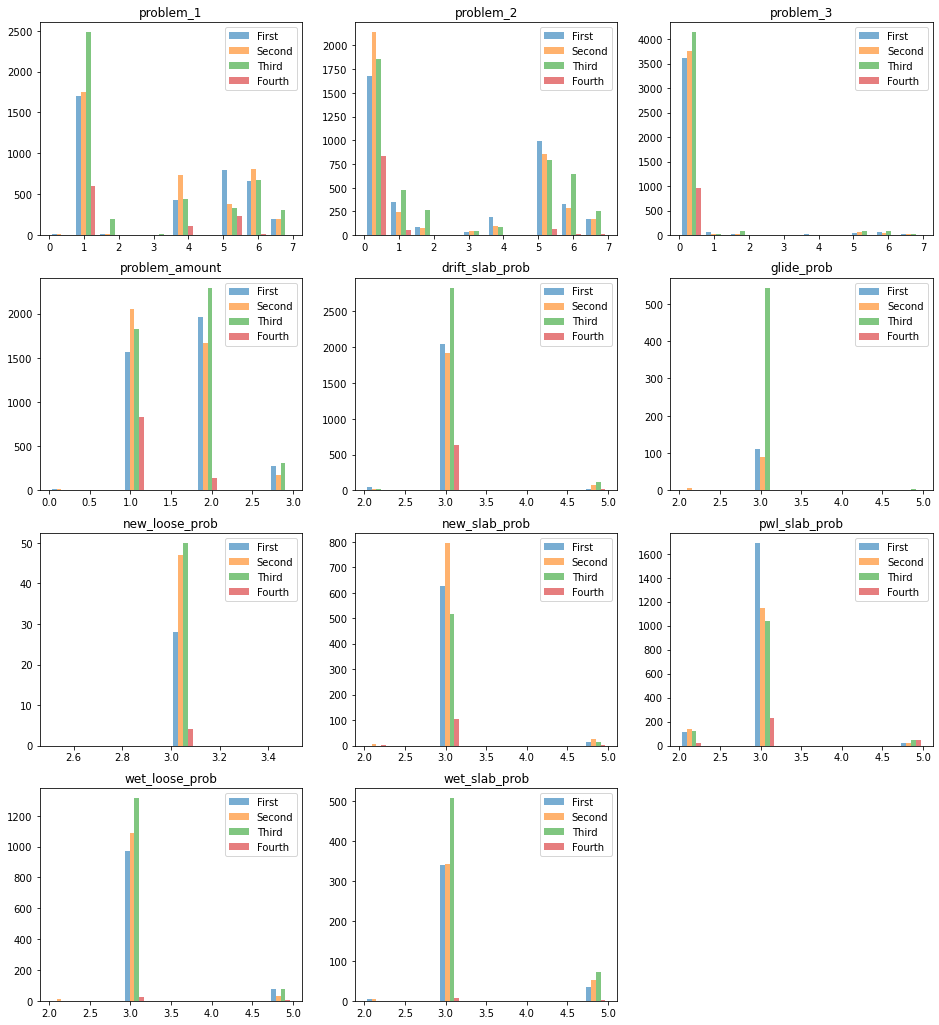

In [40]:
plot_avalanche_problems()

## By region

To group by regions, we first need to reorder the indices of the MultiIndex object.

In [41]:
regions = labeled_data.data.reorder_levels([1, 0])
labels = labeled_data.label.reorder_levels([1, 0])

In [42]:
regions_list = list(np.unique([region for region in labeled_data.data.loc['2017-12-07'].index]))
regions_list

[3003,
 3007,
 3009,
 3010,
 3011,
 3012,
 3013,
 3014,
 3015,
 3016,
 3017,
 3022,
 3023,
 3024,
 3027,
 3028,
 3029,
 3031,
 3032,
 3034,
 3035]

In [43]:
region_3003 = regions.loc[3003]
region_3003

,danger_level_1,emergency_warning_1,problem_amount_1,problem_new_loose_1,problem_wet_loose_1,problem_new_slab_1,problem_drift_slab_1,problem_pwl_slab_1,problem_wet_slab_1,problem_glide_1,...,wind_chg_dir_W_0,wind_chg_dir_NW_0,wind_chg_start_0_0,wind_chg_start_6_0,wind_chg_start_12_0,wind_chg_start_18_0,temp_fl_start_0_0,temp_fl_start_6_0,temp_fl_start_12_0,temp_fl_start_18_0
date,,,,,,,,,,,,,,,,,,,,,
2017-12-02,1.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-03,1.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-04,1.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-05,1.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-06,1.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-08,3.0,1.0,2.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2021-01-09,3.0,1.0,2.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2021-01-10,2.0,1.0,2.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
region_3003.tail()

,danger_level_1,emergency_warning_1,problem_amount_1,problem_new_loose_1,problem_wet_loose_1,problem_new_slab_1,problem_drift_slab_1,problem_pwl_slab_1,problem_wet_slab_1,problem_glide_1,...,wind_chg_dir_W_0,wind_chg_dir_NW_0,wind_chg_start_0_0,wind_chg_start_6_0,wind_chg_start_12_0,wind_chg_start_18_0,temp_fl_start_0_0,temp_fl_start_6_0,temp_fl_start_12_0,temp_fl_start_18_0
date,,,,,,,,,,,,,,,,,,,,,
2021-01-08,3.0,1.0,2.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2021-01-09,3.0,1.0,2.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2021-01-10,2.0,1.0,2.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-11,2.0,1.0,2.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-12,2.0,1.0,2.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
label_3003 = labels.loc[3003]
label_3003

,CLASS_danger_level,CLASS_emergency_warning,CLASS_problem_1,CLASS_problem_2,CLASS_problem_3,CLASS_problem_amount,CLASS_drift_slab_cause,CLASS_drift_slab_dist,CLASS_drift_slab_dsize,CLASS_drift_slab_lev_fill,...,REAL_new_loose_lev_max,REAL_new_loose_lev_min,REAL_new_slab_lev_max,REAL_new_slab_lev_min,REAL_pwl_slab_lev_max,REAL_pwl_slab_lev_min,REAL_wet_loose_lev_max,REAL_wet_loose_lev_min,REAL_wet_slab_lev_max,REAL_wet_slab_lev_min
date,,,,,,,,,,,,,,,,,,,,,
2017-12-02,1,0,1,0,0,1,snowdrift,1,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-03,1,0,1,0,0,1,snowdrift,1,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-04,1,0,1,0,0,1,snowdrift,1,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-05,1,0,1,0,0,1,snowdrift,1,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-06,1,0,1,0,0,1,snowdrift,1,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-08,3,0,1,5,0,2,new-snow,2,3,1,...,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,0.0,0.0
2021-01-09,2,0,1,5,0,2,new-snow,2,2,1,...,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,0.0,0.0
2021-01-10,2,0,1,5,0,2,new-snow,2,2,1,...,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,0.0,0.0


In [46]:
index1 = list(set([column[0] for column in region_3003.columns]))

print(len(index1))
index1

5


['e', 't', 'p', 'w', 'd']

In [47]:
label_3003.columns

Index(['CLASS_danger_level', 'CLASS_emergency_warning', 'CLASS_problem_1',
       'CLASS_problem_2', 'CLASS_problem_3', 'CLASS_problem_amount',
       'CLASS_drift_slab_cause', 'CLASS_drift_slab_dist',
       'CLASS_drift_slab_dsize', 'CLASS_drift_slab_lev_fill',
       'CLASS_drift_slab_prob', 'CLASS_drift_slab_trig', 'CLASS_glide_cause',
       'CLASS_glide_dist', 'CLASS_glide_dsize', 'CLASS_glide_lev_fill',
       'CLASS_glide_prob', 'CLASS_glide_trig', 'CLASS_new_loose_cause',
       'CLASS_new_loose_dist', 'CLASS_new_loose_dsize',
       'CLASS_new_loose_lev_fill', 'CLASS_new_loose_prob',
       'CLASS_new_loose_trig', 'CLASS_new_slab_cause', 'CLASS_new_slab_dist',
       'CLASS_new_slab_dsize', 'CLASS_new_slab_lev_fill',
       'CLASS_new_slab_prob', 'CLASS_new_slab_trig', 'CLASS_pwl_slab_cause',
       'CLASS_pwl_slab_dist', 'CLASS_pwl_slab_dsize',
       'CLASS_pwl_slab_lev_fill', 'CLASS_pwl_slab_prob', 'CLASS_pwl_slab_trig',
       'CLASS_wet_loose_cause', 'CLASS_wet_loose_dis

In [49]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
print("Geometry Column Name : ", countries.geometry.name)
print("Dataset Size : ", countries.shape)
countries.head()

Geometry Column Name :  geometry
Dataset Size :  (177, 6)


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [50]:
'Norway' in countries.name.values

True

In [51]:
norway = countries[countries.name == 'Norway']
norway

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
21,5320045,Europe,Norway,-99,364700.0,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80..."


In [52]:
regions = gpd.read_file('../regions.json')
regions.iloc[0]

safeName                                               Heiane
geometry    POLYGON ((7.110451698906649 59.76332059743837,...
Name: 0, dtype: object

In [53]:
xmin, ymin, xmax, ymax = norway.geometry.total_bounds
polygon = Polygon([(xmin-1, ymin-1), (xmin-1 , 71.5), 
                   (xmax+1, 71.5), (xmax+1, ymin-1), 
                   (xmin+1, ymin-1)])
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=norway.crs)

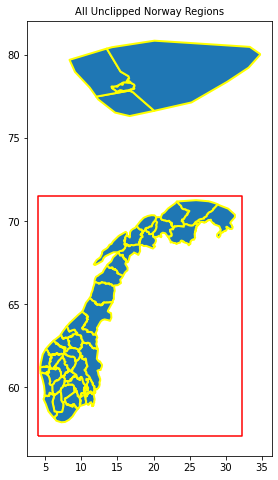

In [59]:
fig, ax = plt.subplots(figsize=(16, 8))

#norway.plot(facecolor='None', edgecolor='yellow', linewidth=2.0, ax=ax)
regions.plot(facecolor='tab:blue', edgecolor='yellow', linewidth=2.0, ax=ax)
poly_gdf.boundary.plot(ax=ax, color="red")

ax.set_title("All Unclipped Norway Regions", fontsize=10)
plt.show()

In [60]:
norway_clipped = gpd.clip(norway, poly_gdf)

to_clip = []
for idx in regions.index:
    if regions.iloc[idx].safeName.startswith('Svalbard') or regions.iloc[idx].safeName == 'Nordenskioldland':
        to_clip.append(idx)
        
regions_clipped = regions.drop(to_clip)

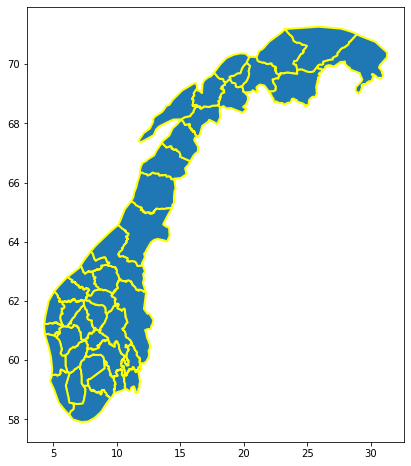

In [61]:
fig, ax = plt.subplots(figsize=(12, 8))

#norway_clipped.plot(facecolor='None', edgecolor='yellow', linewidth=2.0, ax=ax)
regions_clipped.plot(facecolor='tab:blue', edgecolor='yellow', linewidth=2.0, ax=ax)

plt.show()

# Comments

**Summary**: 

**Recommendations**: Based on this analysis, I would recommend...